# Visualizing Flight Data

The AeroSandbox dynamics stack can also be used simply to quickly visualize flight data. Here, we'll use it to visualize GPS data that I recorded during landing of a commercial flight at Boston Logan Airport.

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("./assets/gps_flight_data.csv")
df

,Time (s),Latitude (°),Longitude (°),Altitude (m),Altitude WGS84 (m),Speed (m/s),Direction (°),Distance (km),Horizontal Accuracy (m),Vertical Accuracy (m),Satellites
0,1.084549,42.287006,-70.945528,1628.046271,1599.135742,112.110001,199.000000,0.149722,8.448617,7.418447,0
1,1.894638,42.285722,-70.946074,1622.414572,1593.500488,112.760002,198.300003,0.264182,7.344919,6.870053,22
2,2.890304,42.284743,-70.946505,1618.333304,1589.416504,112.800003,198.399994,0.378811,5.292158,5.302354,23
3,3.898935,42.283765,-70.946944,1614.217371,1585.297852,112.809998,198.300003,0.493062,4.660760,4.448504,23
4,4.894213,42.282787,-70.947370,1607.317252,1578.395020,112.879997,198.199997,0.606016,4.540790,4.398196,23
...,...,...,...,...,...,...,...,...,...,...,...
416,416.898947,42.369362,-71.003499,6.940010,-21.790924,8.170000,315.000000,38.637594,10.232947,3.962276,25
417,417.893231,42.369412,-71.003573,6.395093,-22.335754,8.370000,313.200012,38.646020,10.171674,3.885889,24
418,418.894342,42.369467,-71.003644,6.539099,-22.191650,8.510000,315.000000,38.654957,10.666165,3.841579,24
419,419.898796,42.369521,-71.003725,6.357337,-22.373322,8.280000,309.000000,38.662983,10.767097,3.933756,24


In [9]:
lat_lon_datum = (
    df["Latitude (°)"].mean(),
    df["Longitude (°)"].mean()
)

df["x_e"] = (df["Latitude (°)"] - lat_lon_datum[0]) * (10e6 / 90)
df["y_e"] = (df["Longitude (°)"] - lat_lon_datum[1]) * (10e6 / 90) * np.cosd(lat_lon_datum[0])
N = len(df)

dyn = asb.DynamicsPointMass3DSpeedGammaTrack(
    mass_props=asb.MassProperties(mass=0),
    x_e=df["x_e"].values,
    y_e=df["y_e"].values,
    z_e=-df["Altitude (m)"].values,
    speed=df["Speed (m/s)"].values,
    gamma=np.zeros(N),
    track=np.radians(df["Direction (°)"].values),
)

# Compute gamma and bank from state data
dyn.gamma = np.arcsin(-np.gradient(dyn.z_e) / dyn.speed)

horizontal_load_factor = (
                                 dyn.speed * np.gradient(dyn.track, df["Time (s)"].values, period=2 * np.pi)
                         ) / 9.81
from scipy import ndimage
horizontal_load_factor = ndimage.gaussian_filter1d(horizontal_load_factor, sigma=3)

dyn.bank = np.arctan(horizontal_load_factor)

dyn

DynamicsPointMass3DSpeedGammaTrack instance:
	State variables:
		     x_e: [ 2.21786254e+03  2.07514366e+03  1.966…
		     y_e: [ 5902.55454315  5857.66011382  5822.16…
		     z_e: [-1628.046271   -1622.414572   -1618.33…
		   speed: [112.1100006  112.7600021  112.8000031 …
		   gamma: [-0.05025484 -0.04308253 -0.03634311 -0…
		   track: [3.47320521 3.46098796 3.46273313 3.460…
	Control variables:
		   alpha: 0                                       
		    beta: 0                                       
		    bank: [-7.00659662e-02 -6.45544817e-02 -5.498…
		    Fx_w: 0                                       
		    Fy_w: 0                                       
		    Fz_w: 0                                       

C:\Users\peter\miniconda3\Lib\site-packages\pyvista\jupyter\notebook.py:34: UserWarning:

Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.



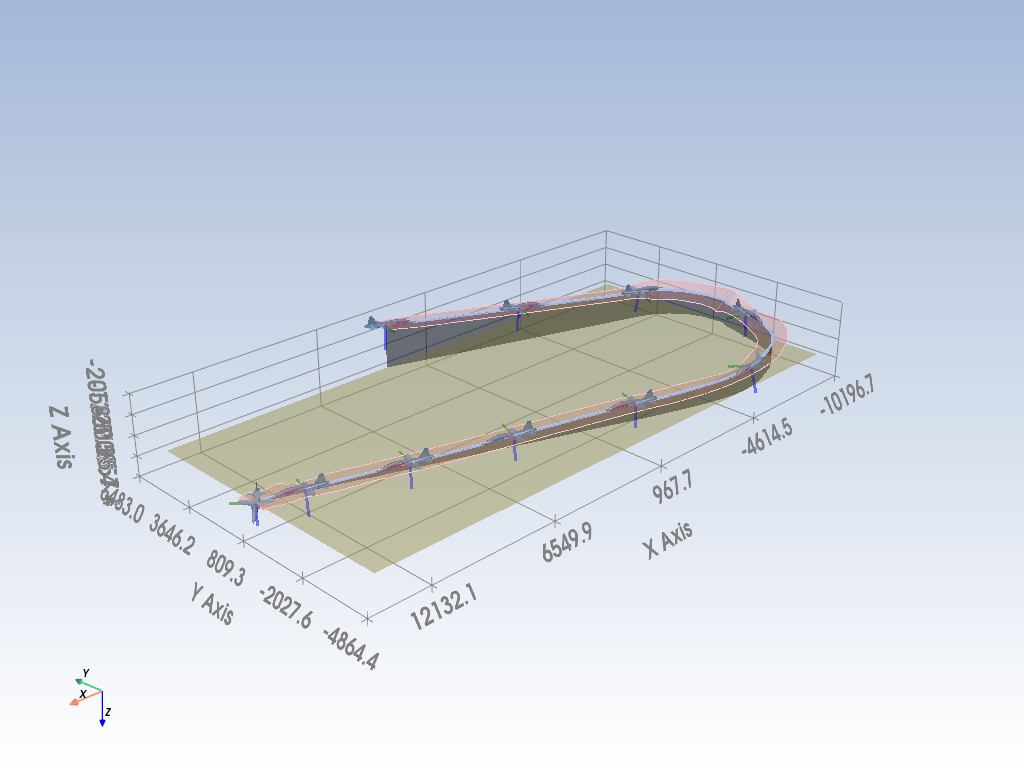

In [11]:
# NBVAL_SKIP

dyn.draw()